In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from matplotlib import style
import seaborn as sns

from scipy.stats import poisson  
from scipy.integrate import odeint

from tqdm import tqdm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

In [3]:
# Import data 
df = pd.read_csv('data/data_provinces.csv').drop('Unnamed: 0', axis = 1)
for column in df.columns:
    df['{}_cum_cases'.format(column)] = np.cumsum(df['{}'.format(column)])


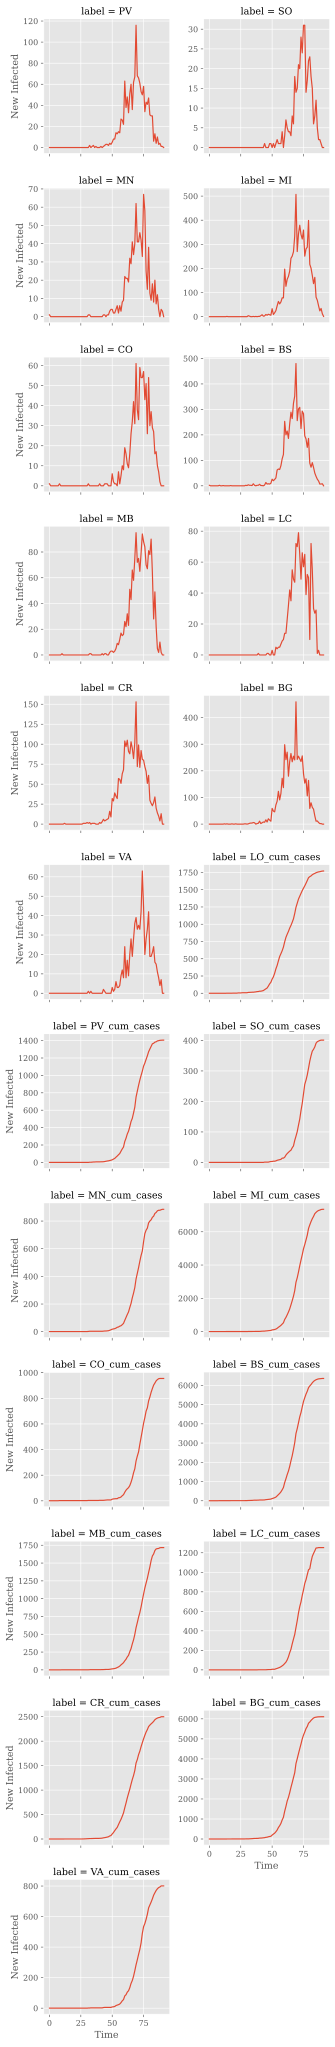

In [4]:
D = df.iloc[:,1:].stack().reset_index()
D.columns = ['time_step', 'label', 'value']

style.use('ggplot')


g = sns.FacetGrid(D, col="label", height=3, col_wrap=2, sharey= False)
g.map(plt.plot, "time_step", 'value')
g.set_axis_labels("Time", "New Infected");

In [5]:
# Define the model used for caibration SEIR
def SIR_eq(INPUT,t, beta, gamma, omega):
    S, E, I, R = INPUT  
    N = S + I + R
    
    dS_dt, dE_dt, dI_dt, dR_dt =  - beta * S * (I / N), beta * S * (I / N) - omega*E, omega*E - gamma * I, gamma * I
        
    return dS_dt, dE_dt, dI_dt, dR_dt

In [6]:
# Define LogLike function
def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i])) 
    return llkh

In [7]:
params_to_consider = {
    'LO': [64, 44928], 'PV': [68, 71882], 'SO': [74, 21477], 'MN': [74,48835], 
    'MI': [68, 1406242], 'CO': [68, 85543], 'BS': [68, 196340], 'MB': [68, 124840], 
    'LC': [70, 48058], 'CR': [66, 72399], 'BG': [66, 120783], 'VA': [73, 80724]
}

# Define global variables
R0s = np.arange(1.5, 4.5, 0.001) # Define R0s to consider
d = 14 # average infection period - based on literature
omega = 1/5

# Store optimization runs 
Best_models = []

for prov, params in params_to_consider.items():
    true_data = df['{}'.format(prov)][:(params[0]-1)]
    
    t = np.arange(1, params[0]+1, 1)
    N = params[1]
    INPUT = N-1, 0, 1, 0 
    
    # Data store
    I_hats = []
    MSEs = []
    llkhs = []
    
    for R0 in tqdm(R0s):
        beta= R0*1/d 
        gamma= 1/d

        # Run the model over time 
        RES = odeint(SIR_eq, INPUT, t, args=(beta, gamma, omega))
        S, E, I_hat, R = RES.T
        I_daily = (I_hat[1:]+R[1:] + E[1:])-(I_hat[:-1]+R[:-1] + E[:-1])

        I_hats.append(I_daily)
    
        MSE = np.sqrt(sum((I_daily-true_data)**2)/len(true_data))
        MSEs.append(MSE)
        
        #Llike
        llkhs.append(compute_loglikelihood(true_data,I_daily))


    cal = pd.DataFrame({'R0': R0s, 'MSE': MSEs, 'llkh': llkhs, 'I_hat': I_hats})
    
    best_model_MSE = cal.loc[cal['MSE'].idxmin()]
    print('BEST MODEL MSE: Region: {}, RO: {}, MSE:{}'.format(prov, round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
    best_model_llkh = cal.loc[cal['llkh'].idxmax()]
    print('BEST MODEL LogLike: Region {}, RO: {}, llkh:{}'.format(prov, round(best_model_llkh['R0'], 4), best_model_llkh['llkh']))
    print("----------------------------------------------------------------")
    
    row = np.array([prov, round(best_model_MSE['MSE'],2), round(best_model_MSE['R0'], 2), round(best_model_llkh['llkh'],2), round(best_model_llkh['R0'], 2)]).reshape(1,5)
    df_ = pd.DataFrame(row, columns=('Province', 'MSE', 'MSE_R0', 'LogLike', "LogLike_R0"))
    Best_models.append(df_)

100%|██████████| 3000/3000 [00:22<00:00, 130.65it/s]


BEST MODEL MSE: Region: LO, RO: 3.58, MSE:9.28
BEST MODEL LogLike: Region LO, RO: 3.627, llkh:-180.82036718313338
----------------------------------------------------------------


100%|██████████| 3000/3000 [00:26<00:00, 114.71it/s]


BEST MODEL MSE: Region: PV, RO: 3.23, MSE:6.14
BEST MODEL LogLike: Region PV, RO: 3.171, llkh:-164.0912246618771
----------------------------------------------------------------


 84%|████████▍ | 2534/3000 [00:26<00:04, 101.40it/s]

In [36]:
df = pd.concat(Best_models)
df

,Province,MSE,MSE_R0,LogLike,LogLike_R0
0,LO,9.28,3.58,-180.82,3.63
0,PV,6.14,3.23,-164.09,3.17
0,SO,2.52,2.54,-99.67,2.39
0,MN,4.82,3.0,-168.87,2.93
0,MI,16.62,3.87,-343.27,3.78
0,CO,3.39,2.8,-113.04,2.63
0,BS,20.59,3.98,-403.27,3.91
0,MB,5.51,3.13,-147.5,2.96
0,LC,5.63,3.06,-180.07,2.92
0,CR,7.61,3.64,-196.01,3.6


In [16]:
# Varese is on the low side in terms of R0 that could be due their population being 
# younger on average 

# We need to look into SO eing the lowest R0 and also at BG being the highest 

<ipython-input-17-a99dd9891fc1>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


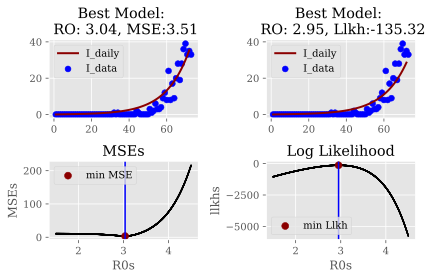

In [17]:
fig, axs = plt.subplots(2,2, facecolor='w')
axs[0,0].set_title('Best Model: \n RO: {}, MSE:{}'.format(round(best_model_MSE['R0'], 2), round(best_model_MSE['MSE'],2)))
axs[0,0].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,0].plot(t[:-1] ,best_model_MSE['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[0,1].set_title('Best Model: \n RO: {}, Llkh:{}'.format(round(best_model_llkh['R0'], 2), round(best_model_llkh['llkh'],2)))
axs[0,1].scatter(t, df['VA'][:73], color = 'b', label = 'I_data')
axs[0,1].plot(t[:-1] ,best_model_llkh['I_hat'], alpha=1, lw=2, label='I_daily', color = 'darkred')

axs[1,0].set_title('MSEs')
axs[1,0].scatter(cal['R0'], cal['MSE'], color = 'k' , s =1 )
axs[1,0].scatter(best_model_MSE['R0'], best_model_MSE['MSE'], color = 'darkred' , s =50, label='min MSE' )
axs[1,0].axvline(x= best_model_MSE['R0'], ymin=0, ymax=2, c= 'b')
axs[1,0].set_xlabel('R0s')
axs[1,0].set_ylabel('MSEs')
    
axs[1,1].set_title('Log Likelihood')
axs[1,1].scatter(cal['R0'], cal['llkh'], color = 'k' , s =1 )
axs[1,1].scatter(best_model_llkh['R0'], best_model_llkh['llkh'], color = 'darkred' , s =50, label='min Llkh' )
axs[1,1].axvline(x= best_model_llkh['R0'], ymin=0, ymax=2, c= 'b')
axs[1,1].set_xlabel('R0s')
axs[1,1].set_ylabel('llkhs')

for i in range(2):
    for z in range(2):
        axs[i,z].legend(fancybox = True)
        for spine in ('top', 'right'): 
            axs[i,z].spines[spine].set_visible(False)
        
fig.tight_layout()
fig.show()